c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Успешное подключение к серверу MongoDB
Нет данных для анализа после очистки. Генерируем случайные данные.


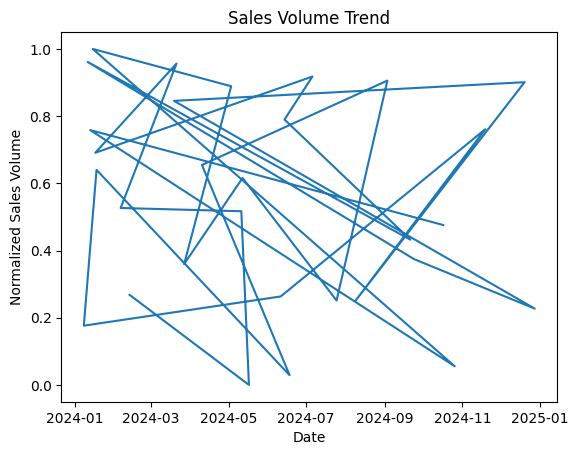

13:45:10 - cmdstanpy - INFO - Chain [1] start processing
13:45:10 - cmdstanpy - INFO - Chain [1] done processing


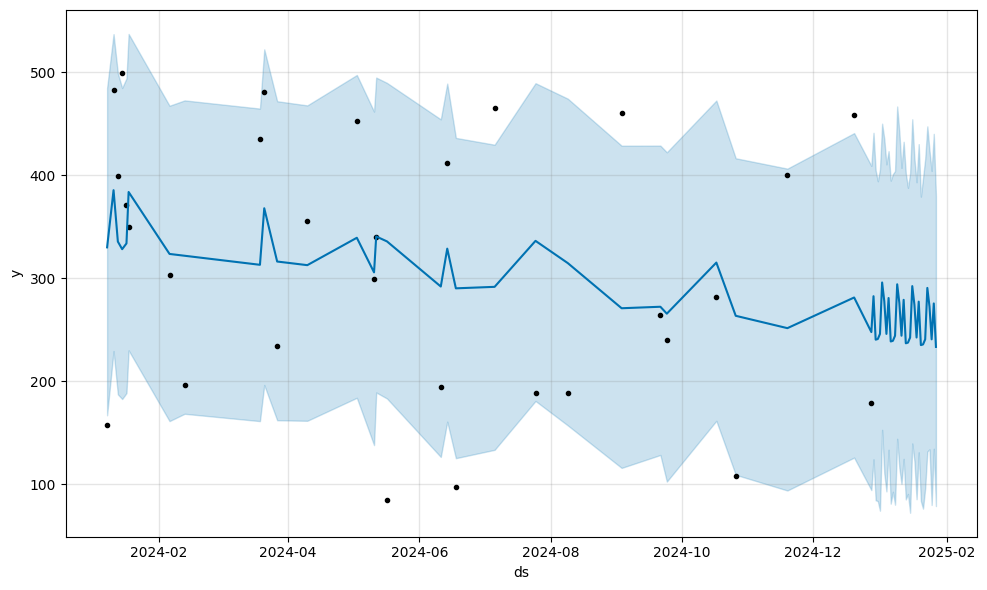

Добавляем тестовый товар: 'MacBook Pro 16 M1 Pro 16 512 (Space Grey)'
Запуск сервера Uvicorn...


INFO:     Started server process [13044]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:65064 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:65064 - "GET /static/styles.css HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:65064 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:65087 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:65089 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:65115 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:65115 - "GET /static/styles.css HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:65115 - "GET /sales HTTP/1.1" 200 OK
INFO:     127.0.0.1:65119 - "GET /static/styles.css HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:65164 - "GET /predict?date=2024-12-01 HTTP/1.1" 200 OK
INFO:     127.0.0.1:65172 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:65182 - "GET /manage_stock HTTP/1.1" 200 OK
Ищем товар: 'macbook pro 16 m1 pro 16 512 (space grey)' (длина строки: 41)
Точное совпадение найдено.
INFO:     127.0.0.1:65202 - "POST /manage_stock HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [13044]


In [ ]:
import pandas as pd
import numpy as np
import pymongo
from prophet import Prophet
import datetime
import random
import matplotlib.pyplot as plt
import nest_asyncio
from bson import ObjectId
from fastapi import FastAPI, Request, Form
from fastapi.responses import HTMLResponse, JSONResponse
import re
from starlette.templating import Jinja2Templates
from fastapi.staticfiles import StaticFiles
import os
import uvicorn

# Устанавливаем соединение с MongoDB
try:
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    db = client["sales_db"]
    print("Успешное подключение к серверу MongoDB")
except Exception as e:
    print(f"Ошибка подключения к MongoDB: {e}")
    exit()

# Создаем коллекции
sales_collection = db["sales"]
products_collection = db["products"]
stocks_collection = db["stocks"]
customers_collection = db["customers"]

# Добавление даты к существующим записям в MongoDB, если она отсутствует
for record in sales_collection.find({"date": {"$exists": False}}):
    random_date = datetime.datetime(2024, random.randint(1, 12), random.randint(1, 28))
    sales_collection.update_one({"_id": record["_id"]}, {"$set": {"date": random_date}})

# Загрузка данных из CSV файла и добавление столбца 'date', если он отсутствует
csv_file_path = "macbook_result_final.csv"
csv_data = pd.read_csv(csv_file_path)

# Преобразование названий столбцов в нижний регистр для унификации
csv_data.columns = [col.lower() for col in csv_data.columns]

# Переименование столбцов, если они не соответствуют требованиям
rename_mapping = {
    'продажи': 'sales_volume'
}
csv_data.rename(columns=rename_mapping, inplace=True)

# Добавление столбца с рандомной датой, если столбца 'date' нет
if 'date' not in csv_data.columns:
    csv_data['date'] = [datetime.datetime(2024, random.randint(1, 12), random.randint(1, 28)) for _ in range(len(csv_data))]

# Добавление данных в MongoDB с сохранением поля 'date'
if "sales_volume" in csv_data.columns and "date" in csv_data.columns:
    if len(csv_data) > 0:
        sales_collection.insert_many(csv_data.to_dict(orient="records"))
    else:
        raise ValueError("CSV файл не содержит данных для загрузки.")
else:
    raise KeyError("CSV файл должен содержать столбцы 'sales_volume' и 'date'")

# Предварительная обработка данных
sales_data = list(sales_collection.find())
sales_df = pd.DataFrame(sales_data)

# Проверяем наличие необходимых столбцов
required_columns = ["sales_volume", "date"]
for column in required_columns:
    if column not in sales_df.columns:
        raise KeyError(f"Не найден необходимый столбец: {column}")

# Очистка данных
sales_df.dropna(inplace=True)

# Проверка наличия данных после очистки
if len(sales_df) == 0:
    print("Нет данных для анализа после очистки. Генерируем случайные данные.")
    sales_df = pd.DataFrame({
        "sales_volume": [random.randint(50, 500) for _ in range(30)],
        "date": [datetime.datetime(2024, random.randint(1, 12), random.randint(1, 28)) for _ in range(30)]
    })

# Нормализация данных
sales_df["normalized_sales"] = (sales_df["sales_volume"] - sales_df["sales_volume"].min()) / (
        sales_df["sales_volume"].max() - sales_df["sales_volume"].min())

# Визуализация данных
plt.plot(sales_df["date"], sales_df["normalized_sales"])
plt.xlabel('Date')
plt.ylabel('Normalized Sales Volume')
plt.title('Sales Volume Trend')
plt.show()

# Разработка модели прогнозирования спроса
model_prophet = Prophet()
train_prophet = sales_df.rename(columns={"date": "ds", "sales_volume": "y"})
model_prophet.fit(train_prophet)

# Прогнозируем на следующий период
future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)
model_prophet.plot(forecast)
plt.show()

# Создаем сайт для взаимодействия с моделью и базой данных
app = FastAPI()
templates = Jinja2Templates(directory="templates")

# Проверяем наличие директории static и создаем её, если не существует
if not os.path.exists("static"):
    os.makedirs("static")

app.mount("/static", StaticFiles(directory="static"), name="static")

def serialize_document(document):
    # Преобразование документа из MongoDB в формат, подходящий для передачи в шаблон
    return {
        "product_name": document.get("Товары", "Неизвестно"),
        "sales_volume": document.get("Продажи", "Неизвестно"),
        "stock": document.get("Запасы", "Неизвестно"),
        "price": document.get("Цена", "Неизвестно"),
        "client": document.get("Клиенты", "Неизвестно"),
        "date": document.get("date", "Неизвестно")
    }

# Добавление тестового товара в базу данных для проверки
test_item_name = "MacBook Pro 16 M1 Pro 16 512 (Space Grey)"
print(f"Добавляем тестовый товар: '{test_item_name}'")

# Добавляем тестовый товар в базу данных
stocks_collection.insert_one({
    "Товары": test_item_name,
    "Продажи": 100,
    "Запасы": 50,
    "Цена": 190990,
    "Клиенты": "Иванов Иван"
})

@app.get("/", response_class=HTMLResponse)
async def home(request: Request):
    return templates.TemplateResponse("index.html", {"request": request})

@app.get("/sales", response_class=HTMLResponse)
async def sales(request: Request):
    sales_data = list(sales_collection.find())
    sales_data = [serialize_document(record) for record in sales_data]
    return templates.TemplateResponse("sales.html", {"request": request, "sales_data": sales_data})

@app.get("/predict", response_class=HTMLResponse)
async def predict_form(request: Request):
    return templates.TemplateResponse("predict_form.html", {"request": request})

@app.post("/predict", response_class=HTMLResponse)
async def predict(request: Request, date: str = Form(...)):
    try:
        # Очистка строки даты
        date = date.strip()
        # Проверка и форматирование даты
        date_obj = datetime.datetime.strptime(date, "%Y-%m-%d")
        future_df = pd.DataFrame({"ds": [date_obj]})
        forecast = model_prophet.predict(future_df)
        predicted_demand = forecast["yhat"].iloc[0]
        return templates.TemplateResponse("predict_result.html", {"request": request, "predicted_demand": predicted_demand, "date": date})
    except ValueError as e:
        # Если формат даты неверный
        print(f"Ошибка формата даты: {e}")
        return templates.TemplateResponse("error.html", {"request": request, "error": f"Неверный формат даты: {str(e)}. Ожидаемый формат: YYYY-MM-DD"})
    except Exception as e:
        # Если возникла другая ошибка
        print(f"Произошла ошибка: {e}")
        return templates.TemplateResponse("error.html", {"request": request, "error": f"Произошла ошибка: {str(e)}"})

@app.get("/manage_stock", response_class=HTMLResponse)
async def manage_stock_form(request: Request):
    return templates.TemplateResponse("manage_stock_form.html", {"request": request})

@app.post("/manage_stock", response_class=HTMLResponse)
async def manage_stock(request: Request, item: str = Form(...), predicted_demand: int = Form(...)):
    # Приведение строки к единому формату перед поиском (удаление лишних пробелов, игнорирование регистра)
    item = item.strip().lower()
    print(f"Ищем товар: '{item}' (длина строки: {len(item)})")

    # Выводим все товары из базы данных
    all_items = list(stocks_collection.find())
    found_match = False

    for itm in all_items:
        original_item = itm.get('Товары', 'Неизвестно')
        item_in_db = original_item.strip().lower()

        if item == item_in_db:
            print("Точное совпадение найдено.")
            stock_data = itm
            found_match = True
            current_stock = stock_data.get("Запасы", 0)
            sales_volume = stock_data.get("Продажи", 0)
            price = stock_data.get("Цена", 0)
            recommendation = ""

            if current_stock < predicted_demand:
                recommendation = "Пополнить запасы"
            elif current_stock > predicted_demand * 1.5:
                recommendation = "Сократить запасы"
            else:
                recommendation = "Запасы в норме"

            return templates.TemplateResponse("manage_stock_result.html", {
                "request": request,
                "recommendation": recommendation,
                "item": stock_data["Товары"],
                "current_stock": current_stock,
                "sales_volume": sales_volume,
                "price": price
            })

    if not found_match:
        print(f"Товар не найден: '{item}'")
    return templates.TemplateResponse("error.html", {"request": request, "error": "Товар не найден"})


if __name__ == "__main__":
    nest_asyncio.apply()
    print("Запуск сервера Uvicorn...")
    uvicorn.run(app, host="127.0.0.1", port=8000)
